## LocalNet: Preserving spatial distancces in Multi-Layer Perceptrons
Standard approaches to multi-layer percpetrons (MLPs) fail to preserve positional information as the input signal traverses through the network. This is because the input signal, a 2d tensor, is typically flattend into a 1d tensor in order to perform linear operations in the forward pass. Through the flattening process, distance information between neighboring pixels is lost, effectively destroying valuable information. The network can (and must) relearn the relations between neighboring pixels, but this is only realized after extensive training. In addition to spending valuable compute time relearning spatial information, the flattening procedure makes is difficult to trace the networks learning process as the MLP acts like a black box. Convolutional neural networks partially mitigate this by tacking on convolutional layers that do preserve the spatial information. However, the MLP head remains a black box.

In this experiment we construct a different type of MLP that preserves spatial information. It accomplishes this by employing a new method for performing linear transformations on 2D tensors that is more amenable to preserving distance information.

### Forward flow of standard MLPs

The forward flow of standard MLPs starts out with a flattening procedure followed by a sequence of linear and non-linear transformations. 

$$U^{ij} \longrightarrow V^I \longrightarrow {A^I}_J V^J + a^J \longrightarrow f(V^J) \longrightarrow {B^I}_J V^J +b^J\,,$$

where ${A^I}_J$ and ${B^I}_J$ are linear transformations, $a^I$ and $b^J$ are their repective biases, and $f$ is the activation function. 

The first step is the flattening procedure transforming the $m\times n$ tensor into a vector of length $m \times n$. In performing this operation, neighboring pixels on adjacent rows in $U^{ij}$ may end up separated from each in $V^J$. Although in theory with knowledge of the flattening procedure one could construct a distance function, in practice the relation between the neighboring pixels is deeply buried requiring the network to relearn this information through extensive training. 

### Preserving distance information
Here we will use tensors in a different way to construct linear transformations that more readily retain spatial information between pixels. Our approach avoids the flattening procedure entirely, allowing one to visualize the linear transformation easily. Consider an $n\times n$ tensor $U^{ij}$ representing a 2d image with $n\times n$ pixels per side. The flattening procedure transforms this to a vector $U^I$ of 1d-dimension $n^2$. A linear transformation, ${L^I}_J$, that preserves the dimensionality of the vector is an $n^2\times n^2$. However, we can avoid the flattening procedure entirely by considering tensors of the form ${M^{ij}}_{kl}$ that maps $n\times n$ tensors to $n\times n$ tensors via bivector multiplication:
$$ U^{ij} \longrightarrow {M^{ij}}_{kl}U^{kl}$$
The operation is clearly a linear transformation that maps matrices to matrices, and it has the same dimension as ${L^I}_J$ as it has dimension $n\times n\times n\times n = n^2\times n^2$.

As the tensor ${M^{ij}}_{kl}$ maps $n\times n$ matrices to $n \times n$ matrices, it readily preserves local information. For example, we can easily define a normalized distance function ${d^{ij}}_{kl}$ that returns the normalized distance between the ${kl}$-pixel in the input space and the ${ij}$-pixel in the target space. For generality, consider the case where $M$ has signature $(m,m,n,n)$ so it can be used to map $n\times n$ tensors to $m\times m$ tensors. The normalized distance tensor is then defined by
$${d^{ij}}_{kl} =  \sqrt{\left(\frac{i}{m}-\frac{k}{n}\right)^2 + \left(\frac{j}{m}-\frac{l}{n}\right)^2}\,.$$

In the models that follow we will make extensive use of the distance function and linear maps of the form ${M^{ij}}_{kl}$ to construct an MLP that preserves spatial information between neighboring pixels. 

## The Models
1. Standard MLP: We start with a standard MLP to set a baseline
2. LocalNet with no localization: MLP utilizing ${M^{ij}}_{kl}$ tensors but no distance information
3. LocalNet with localization: MLP utilizing ${M^{ij}}_{kl}$ and distance-based attenuation at each step
4. LocalNet with Proximity Weight Decay: MLP utilizing ${M^{ij}}_{kl}$ and distance information in the error function

### Importing Packages

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import importlib

### Importing and Processing Data
We will us the standard MNIST dataset for handwritten digit recognition. This set provides readily available benchmarks for comparison, and is quick to train. We use the same dataset for all models. 

In [3]:
from data import load_data

# Create test set and define test dataloader (choose dataset "MNIST" or "FashionMNIST")
train_loader, valid_loader, test_loader = load_data(dataset="MNIST")

### Visualizing the Data

3


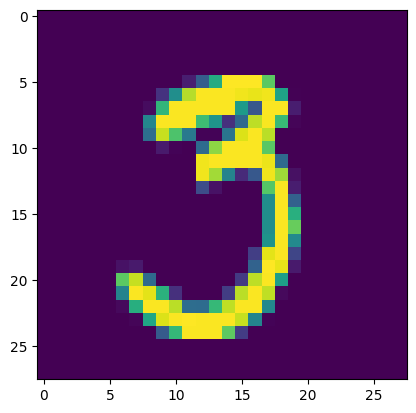

1


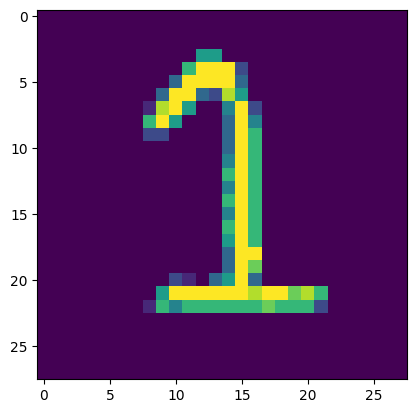

9


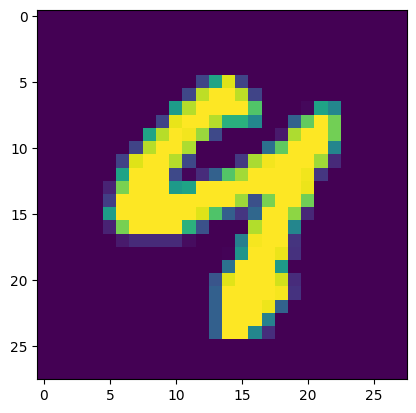

0


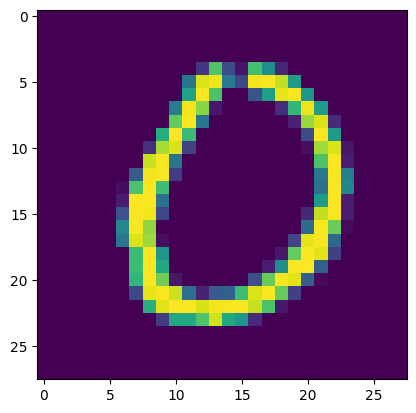

7


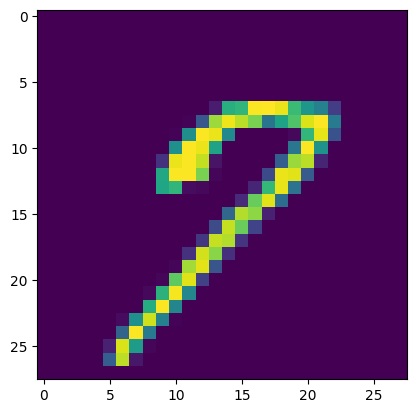

In [3]:
from data import show5
        
# Explore data
show5(test_loader)

# Model \#1: Standard Multi-Layer Perceptron
We start with a standard multi-layer perceptron to classify handrwritten digits in the MNIST data set. This will give us a baseline for comparing to the LocalNet.

In [6]:
from bilinear import Bilinear
import models
from models import get_device
from models import TraditionalNet, LocalNet, train_it, test_it

In [7]:
model1 = TraditionalNet(features=[28*28, 24*24, 16*16, 5*5, 10],
                        learning_rate=.001,
                        momentum=.9,
                        bias=False,
                        save_path="checkpoints/model1.pt"
                 )

print(model1)

TraditionalNet(
  (activation): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=576, bias=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=576, out_features=256, bias=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=256, out_features=25, bias=False)
  (drop3): Dropout(p=0.2, inplace=False)
  (linear4): Linear(in_features=25, out_features=10, bias=False)
  (output): LogSoftmax(dim=1)
  (loss): NLLLoss()
)


Epoch 1/100 completed in 3.353870153427124 seconds on cpu
Training Loss = 2.229904740863379
Validation Loss = 1.9044518016179404
Training Accuracy = 28.263888888888907%
Validation Accuracy = 59.75%
Epoch 2/100 completed in 3.2263641357421875 seconds on cpu
Training Loss = 1.1644521626366497
Validation Loss = 0.6345197835763299
Training Accuracy = 62.41388888888889%
Validation Accuracy = 82.73333333333332%
Epoch 3/100 completed in 3.1922659873962402 seconds on cpu
Training Loss = 0.679820522652732
Validation Loss = 0.43242792556683224
Training Accuracy = 78.90555555555555%
Validation Accuracy = 87.9916666666666%
Epoch 4/100 completed in 3.1013429164886475 seconds on cpu
Training Loss = 0.5238705743816154
Validation Loss = 0.3486561521987119
Training Accuracy = 84.58055555555555%
Validation Accuracy = 90.03333333333333%
Epoch 5/100 completed in 2.964716911315918 seconds on cpu
Training Loss = 0.44246651819679456
Validation Loss = 0.2966265414456528
Training Accuracy = 87.26666666666664%


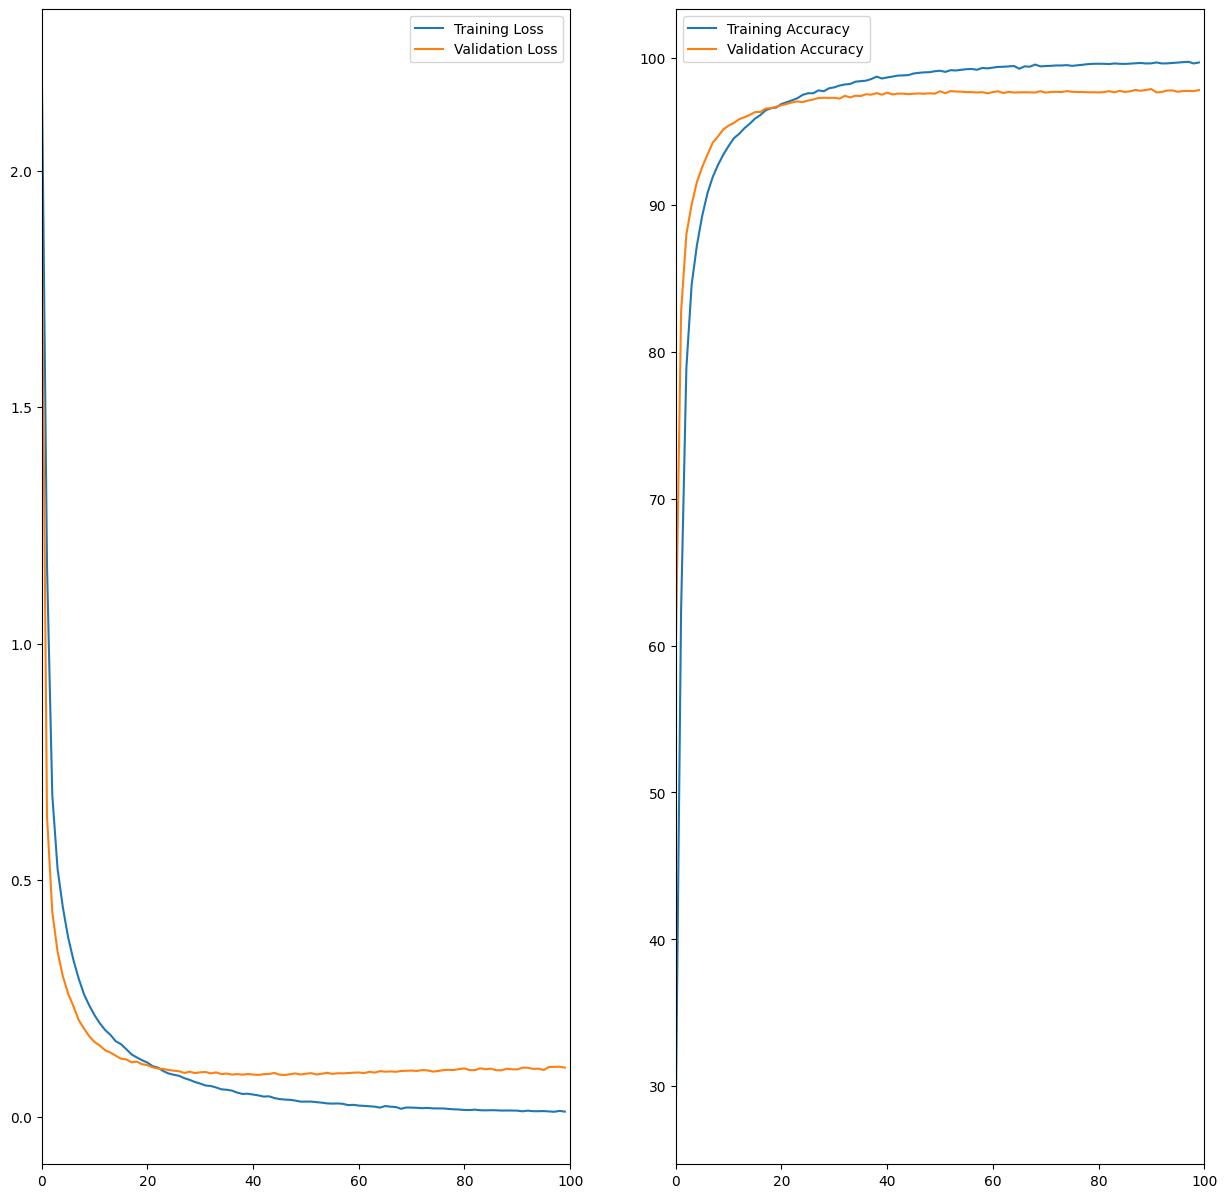

([2.229904740863379,
  1.1644521626366497,
  0.679820522652732,
  0.5238705743816154,
  0.44246651819679456,
  0.37889266253842246,
  0.33125297845072227,
  0.29181619245145046,
  0.25888074759642266,
  0.2350311569836404,
  0.2145456411242486,
  0.19736238976981896,
  0.18321868978937467,
  0.17293607416749,
  0.15958947403977314,
  0.15327108419520988,
  0.1427661931539574,
  0.131746781040397,
  0.1251698354664773,
  0.11938761936086748,
  0.11428016665991804,
  0.10672731629055408,
  0.10380822648542624,
  0.09643467291072014,
  0.09136896356650524,
  0.08866478639592729,
  0.08636872533605323,
  0.08139144302532074,
  0.07784628152433372,
  0.07329462863360013,
  0.06998477154452784,
  0.06587916749405365,
  0.06488885474515463,
  0.06183172154022998,
  0.05790398134332567,
  0.056987356942250496,
  0.05503215384286724,
  0.05084941653793471,
  0.04808272062552472,
  0.0485750863681444,
  0.046776514078335225,
  0.04500482759262538,
  0.042477279427668296,
  0.04313922778941278,
 

In [6]:
train_it(model1, 
         train_loader=train_loader, 
         valid_loader=valid_loader, 
         epochs=100
        )

In [9]:
model1.load_state_dict(torch.load(model1.save_path, map_location="cpu"))
test_it(model1, test_loader)

Test Loss = 0.03364399079518806
Test Accuracy = 99.24166666666666%


# Model \#2: LocalNet with no localization
To demonstrate that the new approach can reproduce the results of a standard MLP, we start with a model that employs the bilinear tensors ${M^{ij}}_{kl}$ but does not utilize pixel distance data.

### Defining Model and Training/Testing Routines
This model uses the "Bilinear" class representing the bilinear tensor ${M^{ij}}_{kl}$, and its associated bias $B^{ij}$, and the LocalNet class that employs the bilinears in the forward and gradient descent steps.

### Model architecture and training
Here we define the model architecture and training/validating/testing routines.

In [10]:
model2 = LocalNet(features=[[28, 28], [24, 24], [16, 16], [5, 5], [10]],
                  learning_rate=.001, 
                  momentum=.9,
                  nonlocal_attenuation=False,
                  nonlocal_penalties=None,
                  save_path="checkpoints/model2.pt",
                  bias=False
                 )

print(model2)

LocalNet(
  (activation): ReLU()
  (bilinear1): Bilinear()
  (drop1): Dropout(p=0.2, inplace=False)
  (bilinear2): Bilinear()
  (drop2): Dropout(p=0.2, inplace=False)
  (bilinear3): Bilinear()
  (drop3): Dropout(p=0.2, inplace=False)
  (bilinear4): Bilinear()
  (output): LogSoftmax(dim=1)
  (loss): NLLLoss()
)


Epoch 1/100 completed in 3.3380560874938965 seconds on cpu
Training Loss = 2.190363697899713
Validation Loss = 1.7007362146377563
Training Accuracy = 30.369444444444444%
Validation Accuracy = 52.06666666666667%
Epoch 2/100 completed in 3.216948986053467 seconds on cpu
Training Loss = 1.0673789959483682
Validation Loss = 0.5611579037904736
Training Accuracy = 65.24444444444444%
Validation Accuracy = 84.94999999999997%
Epoch 3/100 completed in 3.259247064590454 seconds on cpu
Training Loss = 0.6190322945382867
Validation Loss = 0.4140060516993205
Training Accuracy = 81.23888888888885%
Validation Accuracy = 88.56666666666666%
Epoch 4/100 completed in 3.572045087814331 seconds on cpu
Training Loss = 0.4959674350420625
Validation Loss = 0.3557733106712499
Training Accuracy = 85.61388888888887%
Validation Accuracy = 90.325%
Epoch 5/100 completed in 3.629483699798584 seconds on cpu
Training Loss = 0.41698077042897547
Validation Loss = 0.2999233618279299
Training Accuracy = 88.03611111111104%


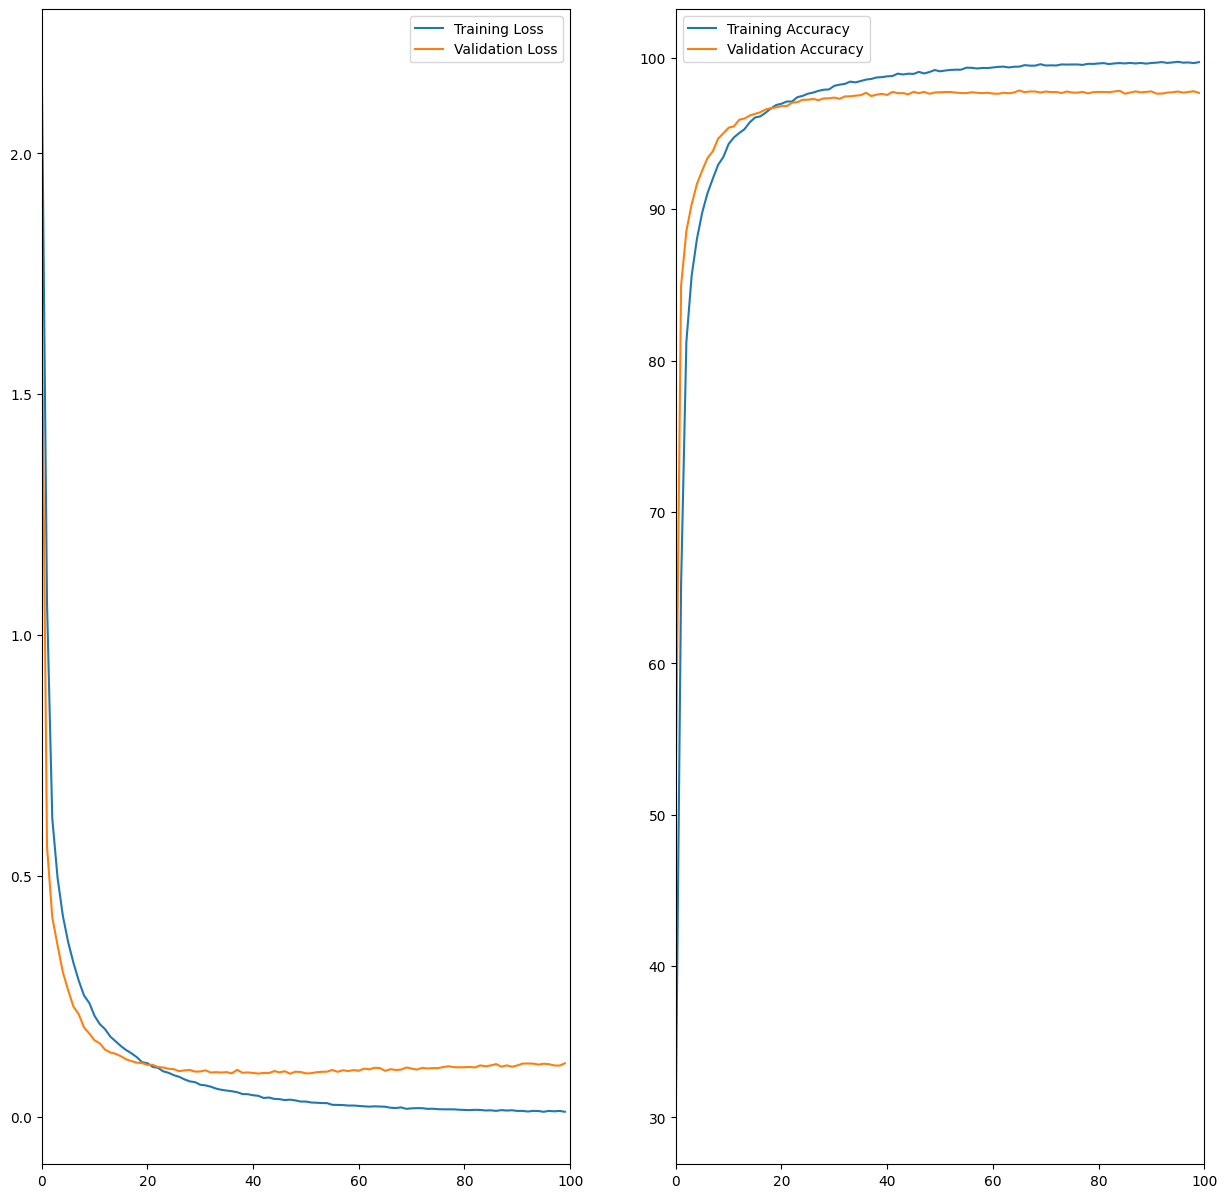

([2.190363697899713,
  1.0673789959483682,
  0.6190322945382867,
  0.4959674350420625,
  0.41698077042897547,
  0.3626219772630267,
  0.31964170469178077,
  0.28265487568908293,
  0.2518279716372493,
  0.23617856977217722,
  0.2093155382523935,
  0.19216952903899887,
  0.18156747305724374,
  0.16613262290673145,
  0.15632784636980954,
  0.14646078623914055,
  0.13818315973795137,
  0.131519944699274,
  0.12360116232020968,
  0.11297687953420807,
  0.1111490694528653,
  0.10338660382562218,
  0.10150981166938113,
  0.0941846172134909,
  0.09115716009069641,
  0.08621662066545747,
  0.08286980353544153,
  0.0775549814686593,
  0.0733712705108854,
  0.07178803700498412,
  0.06627691296384572,
  0.06506107631346404,
  0.06228410530861263,
  0.05829769770035313,
  0.05584640216392775,
  0.054310278767512904,
  0.05281622734376124,
  0.05084324608453448,
  0.04701501375643744,
  0.04671116871785163,
  0.04459020880278609,
  0.04326044195724862,
  0.03884617849346243,
  0.03985390292449542,
 

In [9]:
train_it(model2, 
         train_loader=train_loader, 
         valid_loader=valid_loader, 
         epochs=100
        )

In [11]:
model2.load_state_dict(torch.load(model2.save_path, map_location="cpu"))
test_it(model2, test_loader)

Test Loss = 0.036183510783730534
Test Accuracy = 99.26666666666668%


### Visualizing the Forward Pass
The bilinear forward pass carries the advantage that we can easily visualize the effect of the operations at each step. Here we visualize the forward pass of a binlinear net without localization built in. Without localization, we see no easily identifiable structures or patterns emerging. 

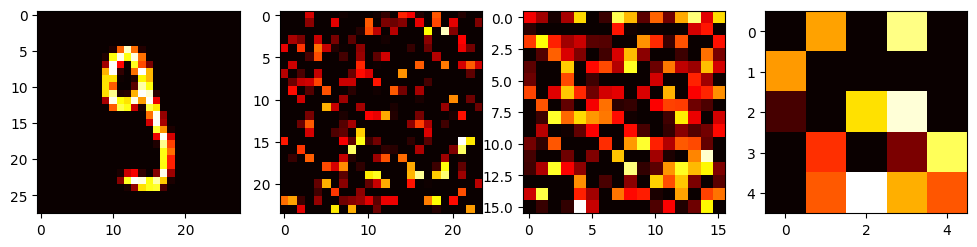

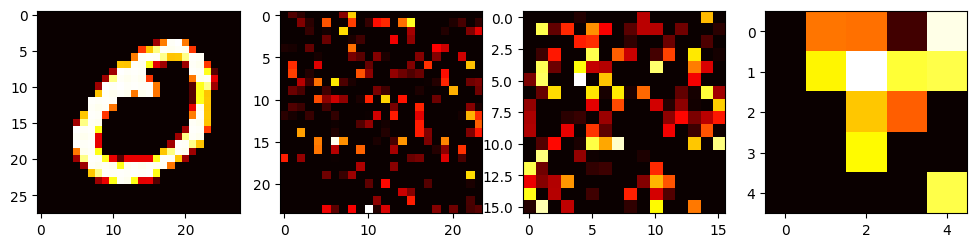

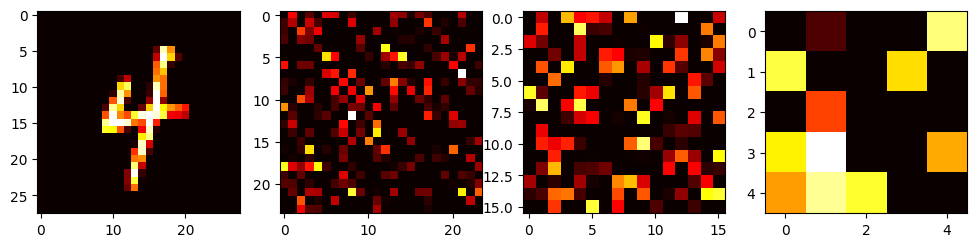

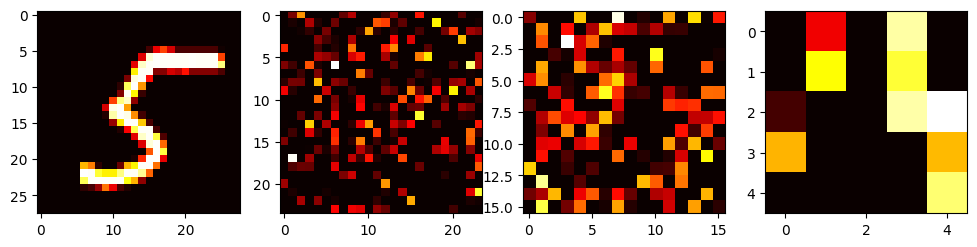

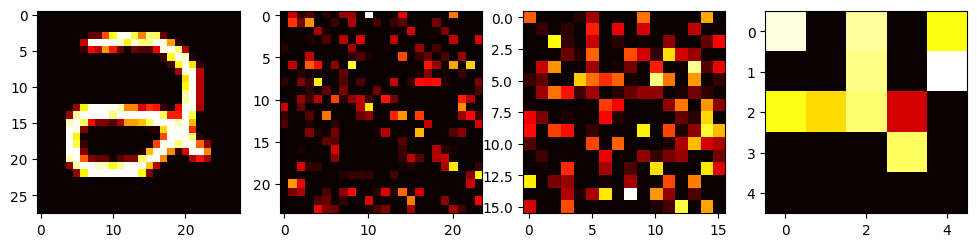

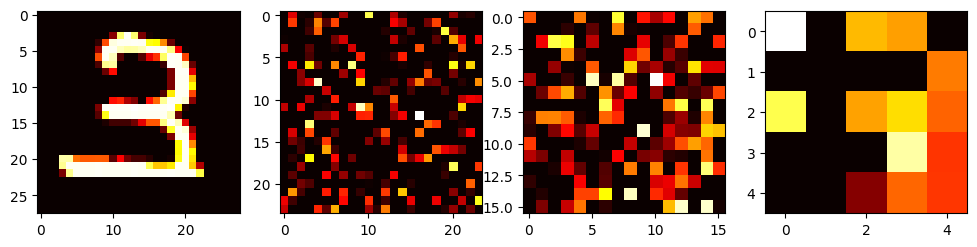

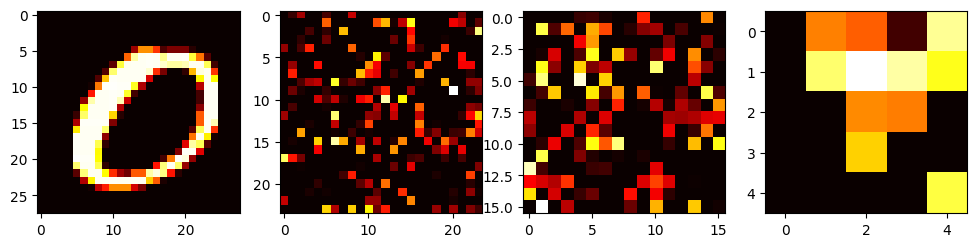

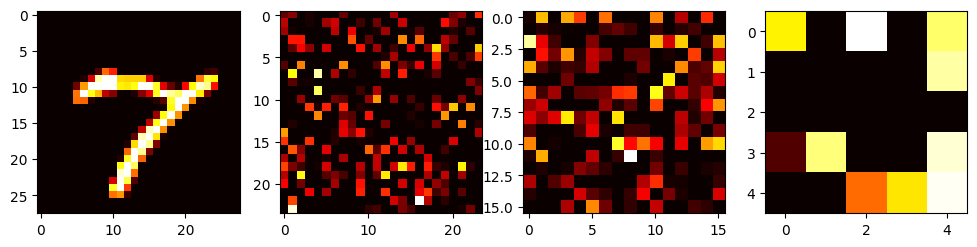

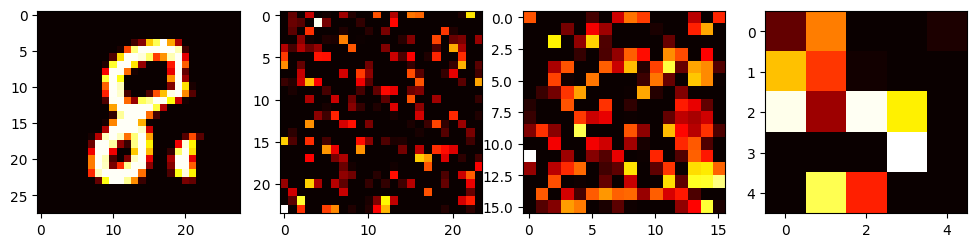

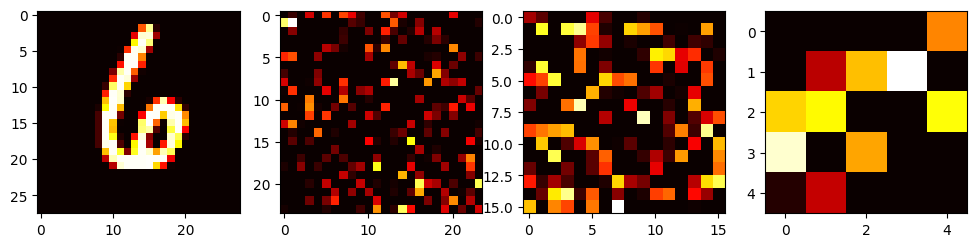

In [49]:
from models import visualize_forward_pass

visualize_forward_pass(model2, test_loader, N=10, cmap="hot")

## Model \#3: LocalNet with Localized Initialization
In this model we extend the previous model, but begin by randomimizing the linear transforms such that the standard deviation is a function of the normalized distance between the input and target pixels. 

### Visualizing Gaussian Localization
Here we visualize the effect of nonlocal attenuation of the Bilinear transformations. We first create bilinear with weights attenuated by a Gaussian function of distance. The Gaussian depends on the (normalized) squared distance between the input pixel and the output pixel. The effect is clear: it constrains the transformation to be localized.

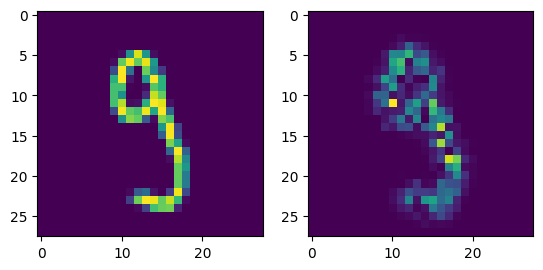

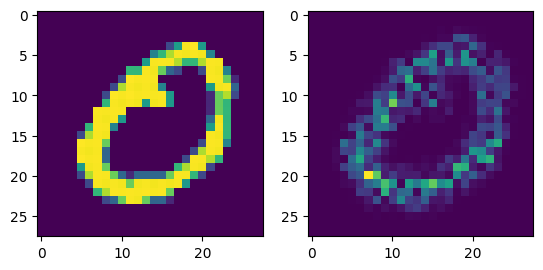

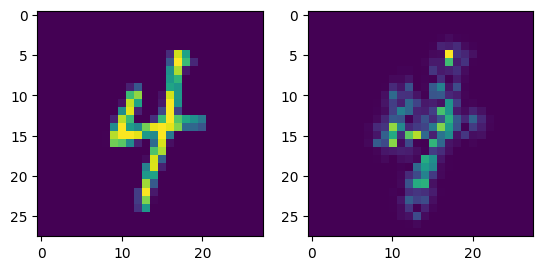

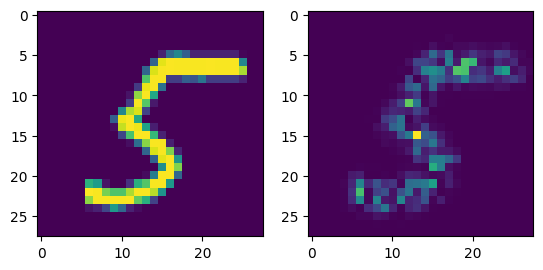

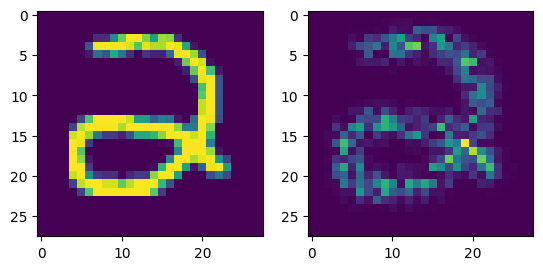

In [13]:
from bilinear import visualize_local_tensors
        
# Explore data
visualize_local_tensors(test_loader)

### Defining the model
The model is defined as above but with init_type="gaussian" to initialize the tensors with local information.

In [14]:
model3 = LocalNet(features=[[28, 28], [24, 24], [16, 16], [5, 5], [10]],
                  learning_rate=.001, 
                  momentum=.9, 
                  nonlocal_attenuation=True,
                  nonlocal_penalties= None,
                  gaussian_std=.05, 
                  bias=False,
                  save_path="checkpoints/model3.pt",
                 )

print(model3)

LocalNet(
  (activation): ReLU()
  (bilinear1): Bilinear()
  (drop1): Dropout(p=0.2, inplace=False)
  (bilinear2): Bilinear()
  (drop2): Dropout(p=0.2, inplace=False)
  (bilinear3): Bilinear()
  (drop3): Dropout(p=0.2, inplace=False)
  (bilinear4): Bilinear()
  (output): LogSoftmax(dim=1)
  (loss): NLLLoss()
)


Epoch 1/200 completed in 3.8915610313415527 seconds on cpu
Training Loss = 2.2253617603513938
Validation Loss = 1.9051139415105185
Training Accuracy = 14.786111111111111%
Validation Accuracy = 38.11666666666669%
Epoch 2/200 completed in 4.044316053390503 seconds on cpu
Training Loss = 1.794609235975478
Validation Loss = 1.2841241952578222
Training Accuracy = 35.76666666666668%
Validation Accuracy = 63.09166666666667%
Epoch 3/200 completed in 3.9308321475982666 seconds on cpu
Training Loss = 1.4124763725598664
Validation Loss = 0.8448093270460765
Training Accuracy = 50.43055555555558%
Validation Accuracy = 77.24999999999997%
Epoch 4/200 completed in 3.8149256706237793 seconds on cpu
Training Loss = 1.1590130407545318
Validation Loss = 0.6755602983633687
Training Accuracy = 59.90833333333336%
Validation Accuracy = 82.86666666666667%
Epoch 5/200 completed in 3.8861560821533203 seconds on cpu
Training Loss = 1.0323721820248497
Validation Loss = 0.5765501300493872
Training Accuracy = 65.227

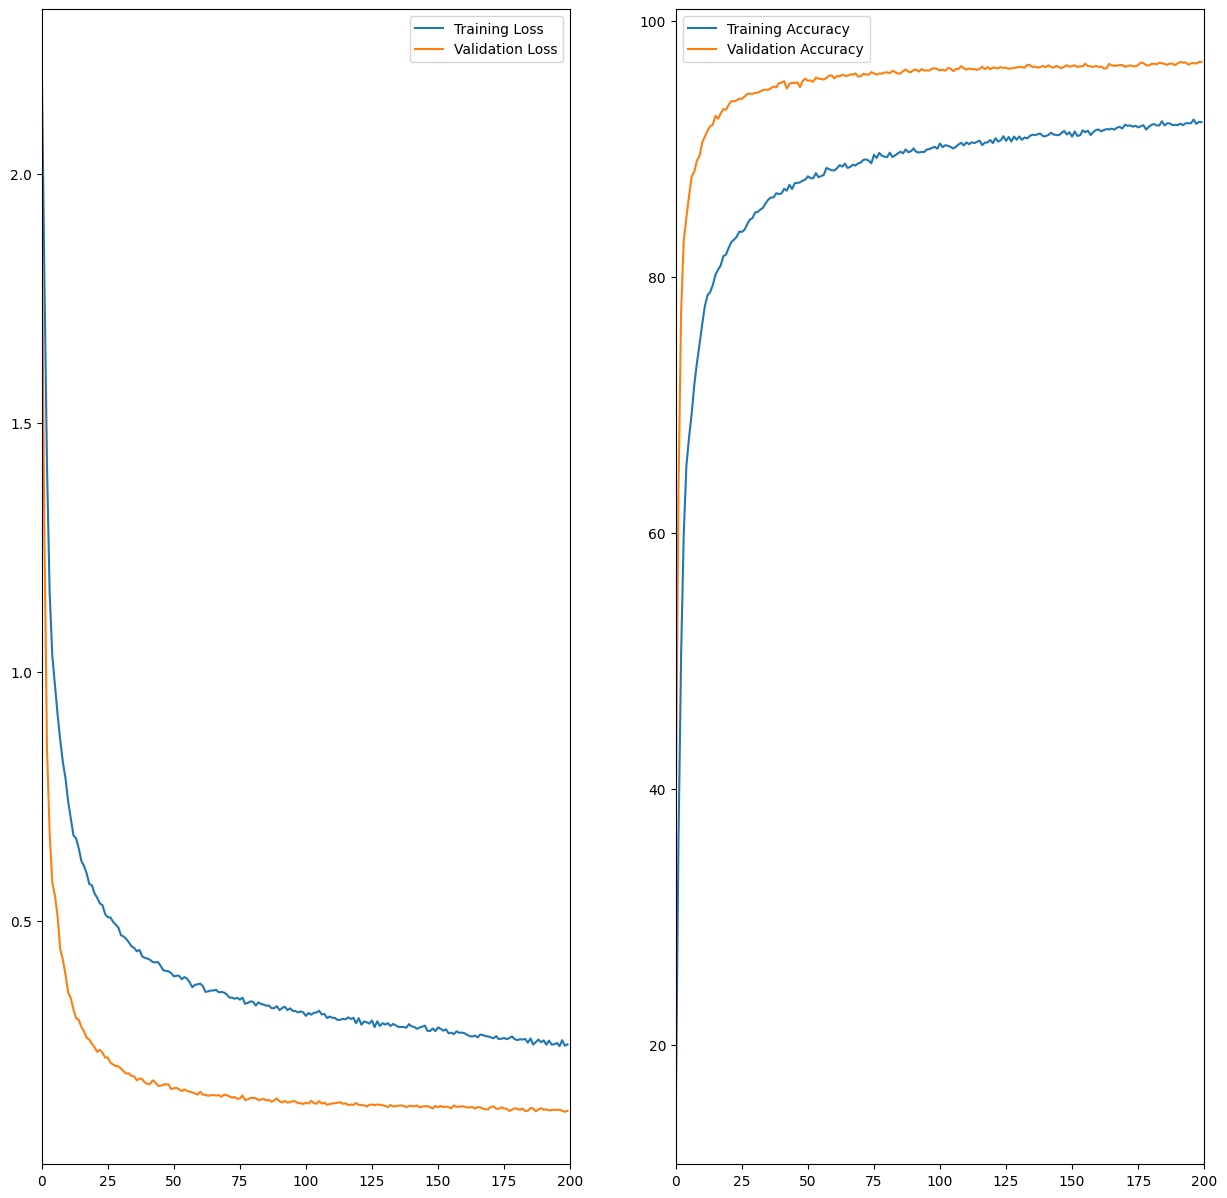

([2.2253617603513938,
  1.794609235975478,
  1.4124763725598664,
  1.1590130407545318,
  1.0323721820248497,
  0.9741199362542894,
  0.9146743772824604,
  0.862292917595969,
  0.8187243118286136,
  0.7856602432727815,
  0.7394851460721757,
  0.7053464570310376,
  0.6714569461213213,
  0.6651947347058184,
  0.6455468380583659,
  0.6199108542601266,
  0.6098514561918049,
  0.5951245110564756,
  0.5734747575653928,
  0.5709747222132157,
  0.5546662009689547,
  0.5457378298309117,
  0.5345733943250434,
  0.5309807641108829,
  0.5133754433658386,
  0.5067285865147905,
  0.5063080247773063,
  0.4976798872285414,
  0.4918662481241756,
  0.48632728371355266,
  0.47068177177508674,
  0.46805681530634563,
  0.4631408459279272,
  0.4561428863339954,
  0.44831446173455985,
  0.4451816404395632,
  0.43828264883491735,
  0.4412241223918066,
  0.4282574728594887,
  0.42516400554445066,
  0.42372325775358427,
  0.42136453707350613,
  0.41677618814839246,
  0.41598910950289825,
  0.41675589874055646,
 

In [33]:
train_it(model3, 
         train_loader=train_loader, 
         valid_loader=valid_loader, 
         epochs=200
        )

In [15]:
model3.load_state_dict(torch.load(model3.save_path, map_location="cpu"))
test_it(model3, test_loader)

Test Loss = 0.08605069065839056
Test Accuracy = 97.61666666666666%


## Visualizing the forward pass
This model uses localization by attentuating the bilinear map with the distance function at ech step. Here we can see some structural patterns emerge as network pushes the image through the funnel. We can clearly see the effect of localization as the map tends to map pixels in the input to nearby pixels in the output. However, the mapped pixels are sparse, and it is still difficult to see new features emerging. 

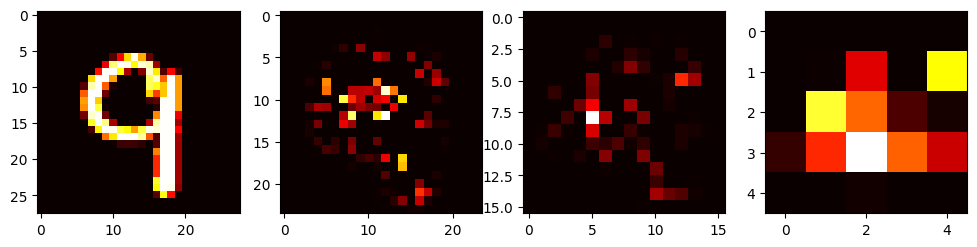

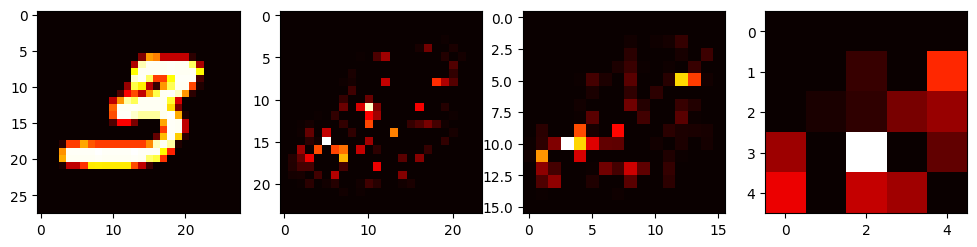

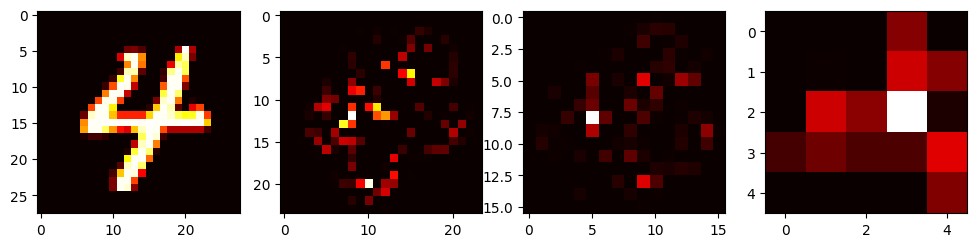

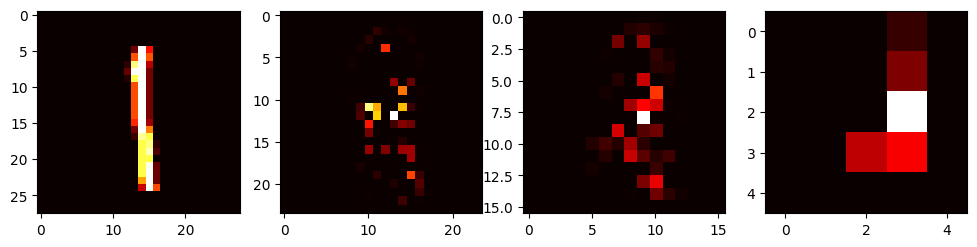

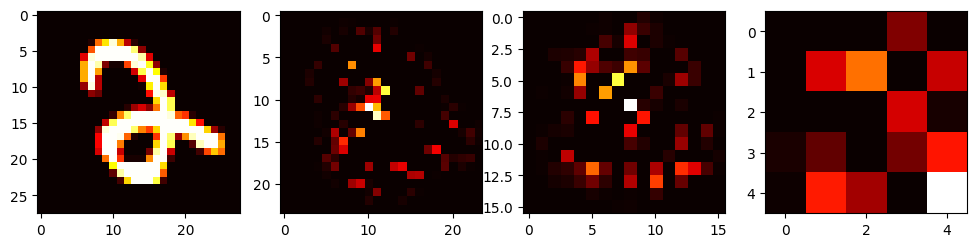

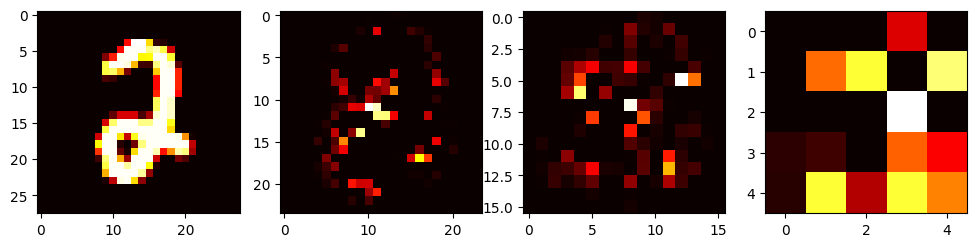

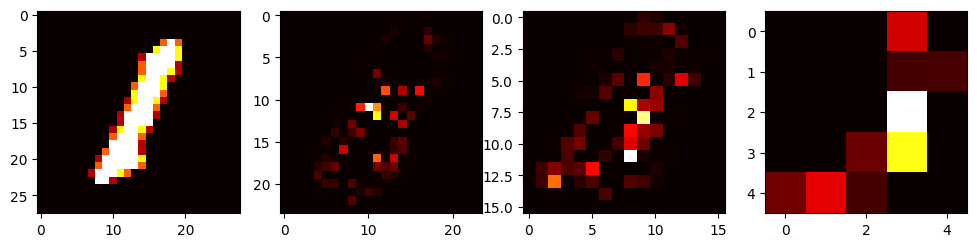

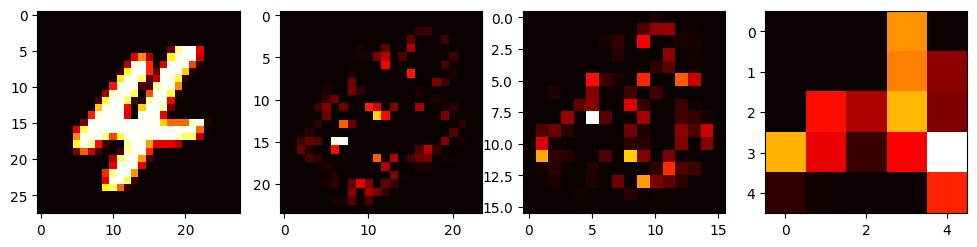

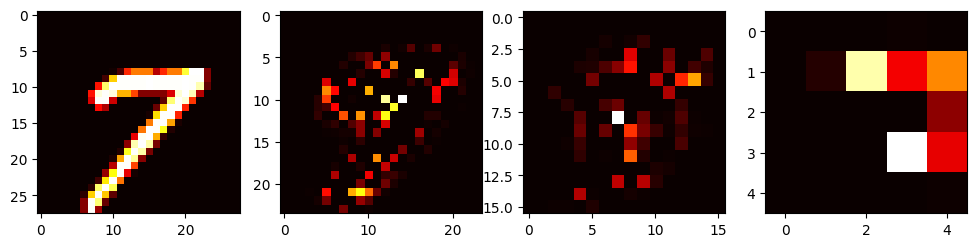

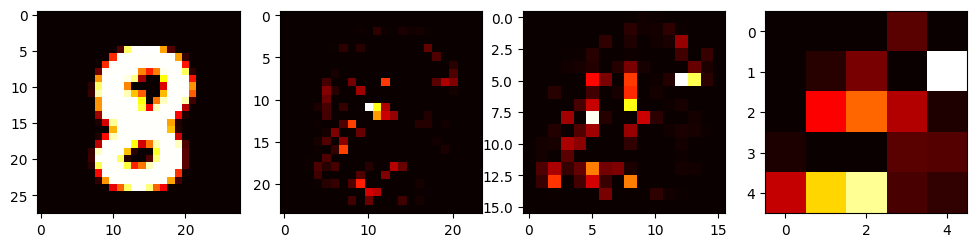

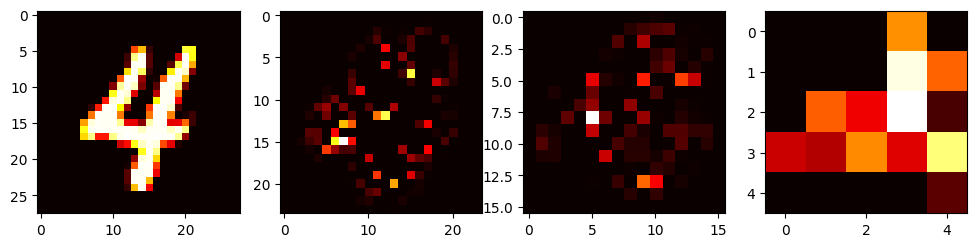

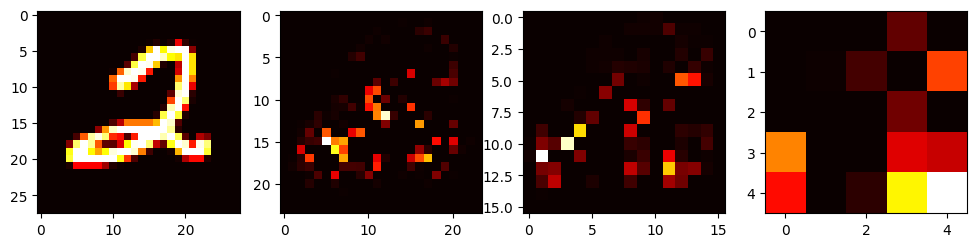

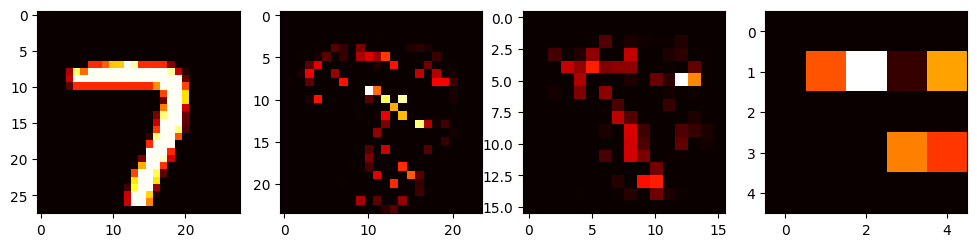

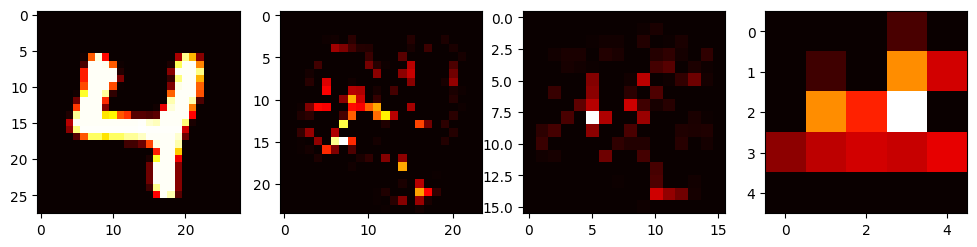

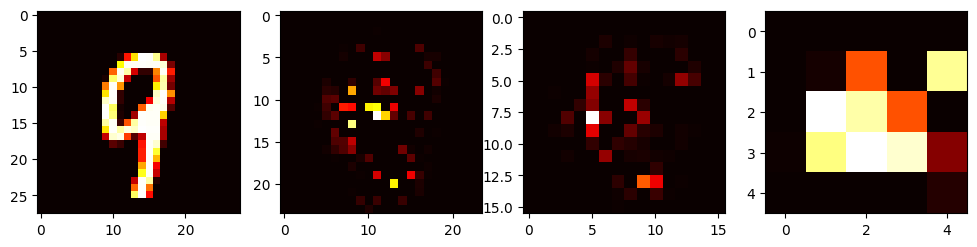

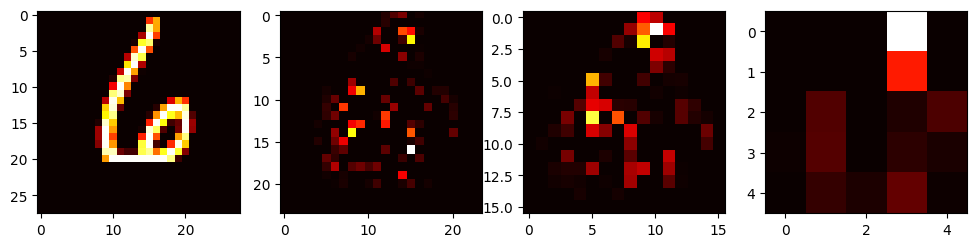

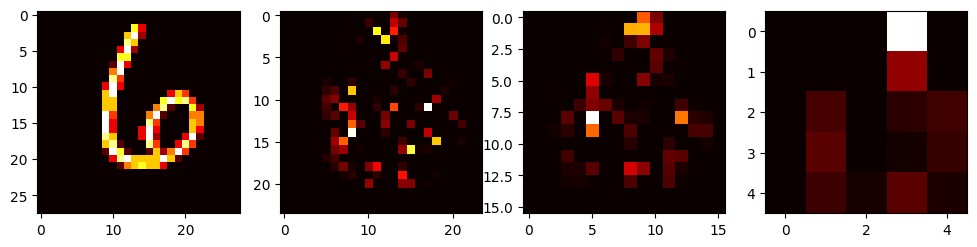

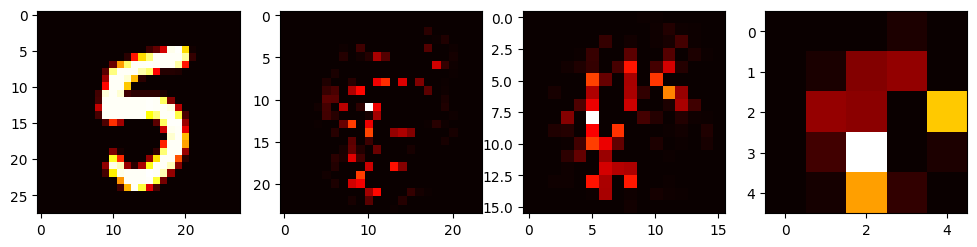

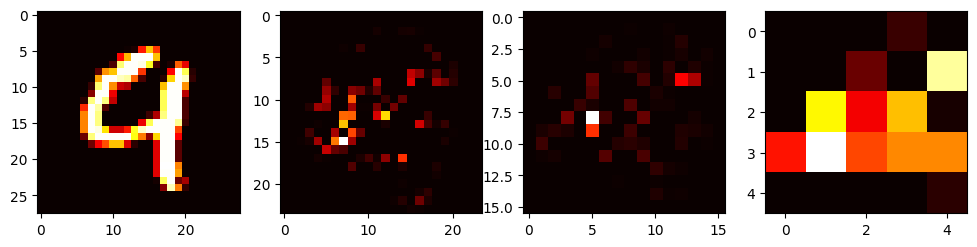

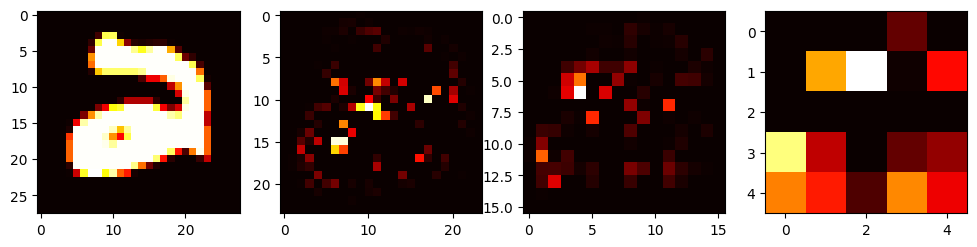

In [47]:
# Explore data
visualize_forward_pass(model3, train_loader, N=20, cmap="hot")

## Model \#4: LocalNet with Nonlocal Weight Decay
In the final model we show that we can force localization by including a nonlocal penalty in the loss function. This penalty is analagous to the L2 weight decay term, but our term explicitly depends on the normalized distance between input and target pixels. Explicitly, the new error terms are defined as follow. First we define the normalized distance bilinear that returns the normalized distance between input and output pixels:
$${d^{ij}}_{kl} =  \sqrt{\left(\frac{i}{m}-\frac{k}{n}\right)^2 + \left(\frac{j}{m}-\frac{l}{n}\right)^2}\,.$$
The weights are then multiplied by the distance function:
$${M^{ij}}_{kl} \  \longrightarrow \  {W^{ij}}_{kl} = {d^{ij}}_{kl} * {M^{ij}}_{kl}$$
We then add a new weight decay term to the error function:
$$ Loss \ \longrightarrow \ Loss + \lambda_1 W^{1}_{ijkl}W_{1}^{ijkl}+\lambda_2 W^{2}_{ijkl}W_{2}^{ijkl}+\lambda_3 W^{3}_{ijkl}W_{3}^{ijkl}\,. $$

Unlike in the previous model with nonlocal attentuation, in this model the forward pass uses the non-attenuated bilinears ${M^{ij}}_{kl}$, relying on the gradient descent of the nonlocal penalty in the loss term to enforce locality.

In [17]:
model4 = LocalNet(features=[[28, 28], [24, 24], [16, 16], [5, 5], [10]],
                  learning_rate=.001, 
                  momentum=.9, 
                  nonlocal_penalties= [5, .5, .05],
                  bias=False,
                  save_path="checkpoints/model4.pt",
                 )

print(model4)

LocalNet(
  (activation): ReLU()
  (bilinear1): Bilinear()
  (drop1): Dropout(p=0.2, inplace=False)
  (bilinear2): Bilinear()
  (drop2): Dropout(p=0.2, inplace=False)
  (bilinear3): Bilinear()
  (drop3): Dropout(p=0.2, inplace=False)
  (bilinear4): Bilinear()
  (output): LogSoftmax(dim=1)
  (loss): NLLLoss()
)


Epoch 1/200 completed in 5.222944021224976 seconds on cpu
Training Loss = 8.764585744221998
Validation Loss = 2.732765544891359
Training Accuracy = 22.561111111111103%
Validation Accuracy = 36.066666666666684%
Epoch 2/200 completed in 5.273092746734619 seconds on cpu
Training Loss = 2.544786643981933
Validation Loss = 2.4405629107157387
Training Accuracy = 28.80833333333332%
Validation Accuracy = 31.308333333333334%
Epoch 3/200 completed in 5.348416090011597 seconds on cpu
Training Loss = 2.400082920074464
Validation Loss = 2.370171820322672
Training Accuracy = 25.519444444444446%
Validation Accuracy = 20.366666666666664%
Epoch 4/200 completed in 5.048585891723633 seconds on cpu
Training Loss = 2.3492119053734672
Validation Loss = 2.315929454167686
Training Accuracy = 17.858333333333338%
Validation Accuracy = 15.591666666666667%
Epoch 5/200 completed in 5.090923070907593 seconds on cpu
Training Loss = 2.232072505950926
Validation Loss = 2.136083464304606
Training Accuracy = 17.73055555

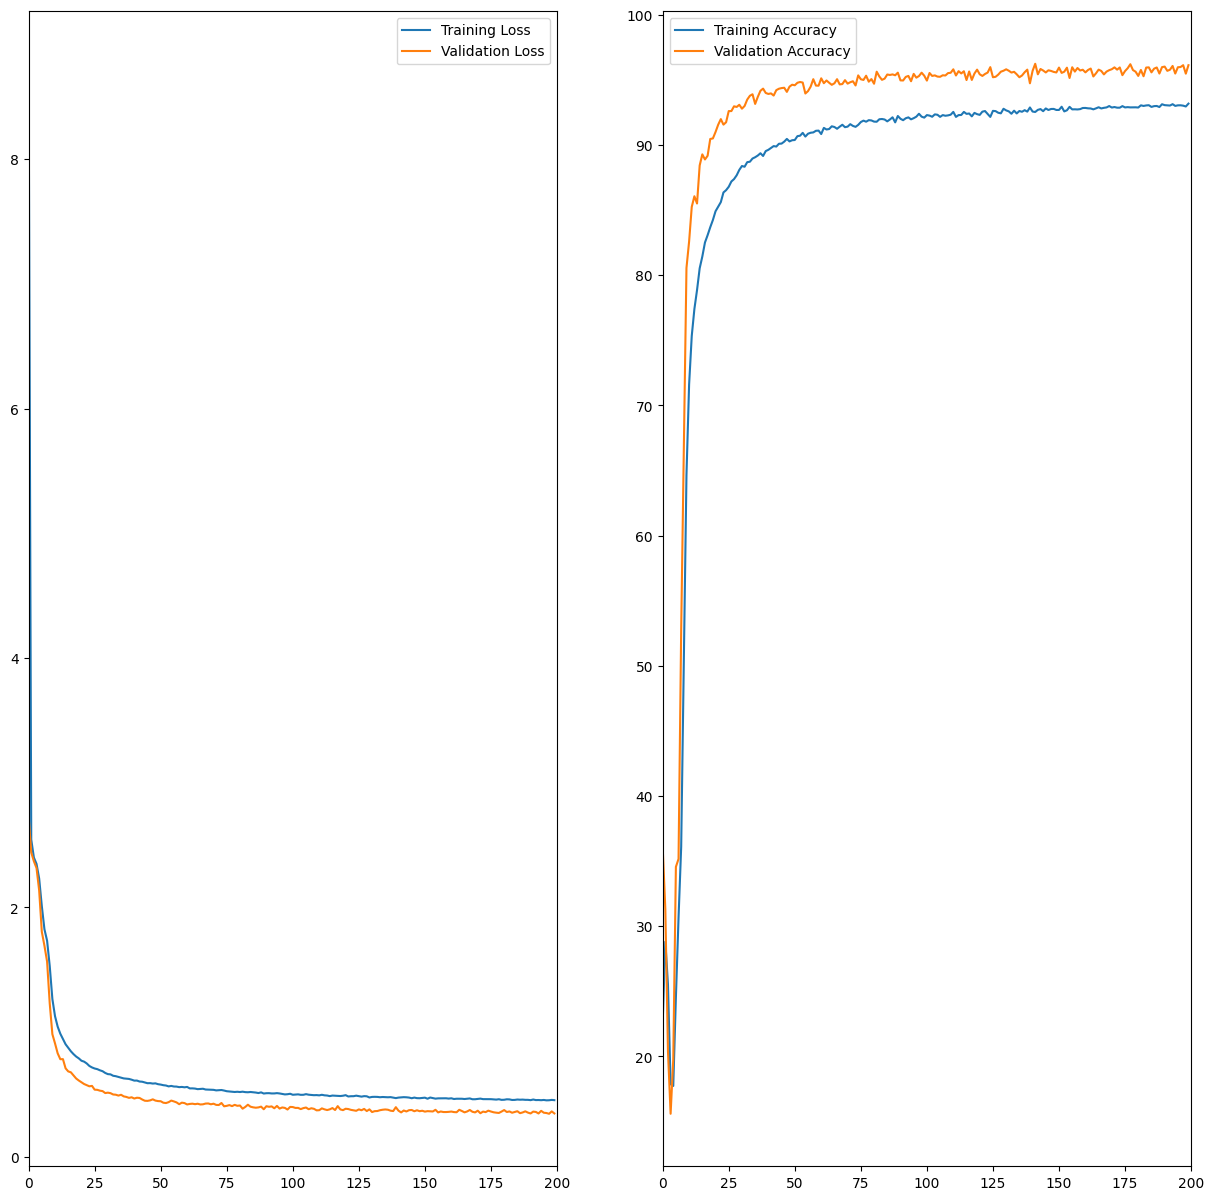

([8.764585744221998,
  2.544786643981933,
  2.400082920074464,
  2.3492119053734672,
  2.232072505950926,
  2.0111642399893874,
  1.8245933521058828,
  1.733218559053209,
  1.5298140755759344,
  1.2655265198813532,
  1.1281441389719633,
  1.044621892929077,
  0.9875553617477427,
  0.945521978961097,
  0.9028552462259927,
  0.8748075563112893,
  0.846646722157796,
  0.8238410808245344,
  0.8043470351431102,
  0.7897103379302549,
  0.770925545665953,
  0.7635949375099605,
  0.7491152684423655,
  0.7289418969684183,
  0.717031833542718,
  0.708526475826899,
  0.70338452662362,
  0.6940522094832523,
  0.6868065260251364,
  0.6728690230846396,
  0.6634869768089721,
  0.6615404286914398,
  0.6502865739928353,
  0.6468159001403386,
  0.641086791144477,
  0.6356526861985522,
  0.6291397015783525,
  0.6273996441629198,
  0.6248993945916492,
  0.6188075828287339,
  0.6114399584929149,
  0.611814843283759,
  0.604133943425284,
  0.6025018741554695,
  0.5967447455724078,
  0.5905984641446009,
  0.

In [37]:
train_it(model4, 
         train_loader=train_loader, 
         valid_loader=valid_loader, 
         epochs=200
        )

In [18]:
model4.load_state_dict(torch.load(model4.save_path, map_location="cpu"))
test_it(model4, test_loader)

Test Loss = 0.33577862449487045
Test Accuracy = 96.39166666666662%


### New Structure Emerging
With this model we can clearly see new structure emerging as the neural net tries to isolate and enhance features. Here are some of the patterns that emerge:
- The lower left "elbow" of the 4 is enhanced and isolated
- Vertically oriented 1s are collapsed to a prominent point that persists through the hidden layers
- Diagonally oreiented 1s are retained with faint loops added as the net tries to determine if the line is the diagonal of an 8
- A faint internal loop is added to 0s, possibly because the net is trying to determine if the character is a 6
- The upper horizontal line in 7 is enhanced and isolated

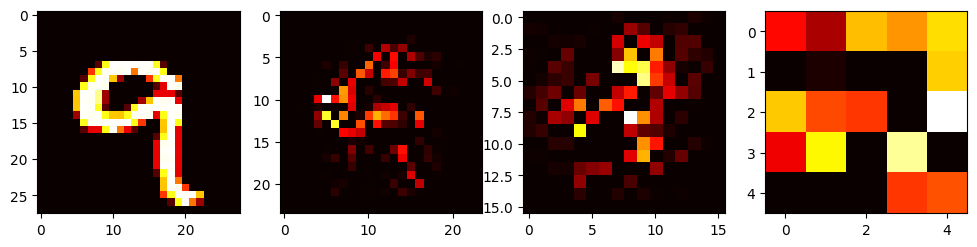

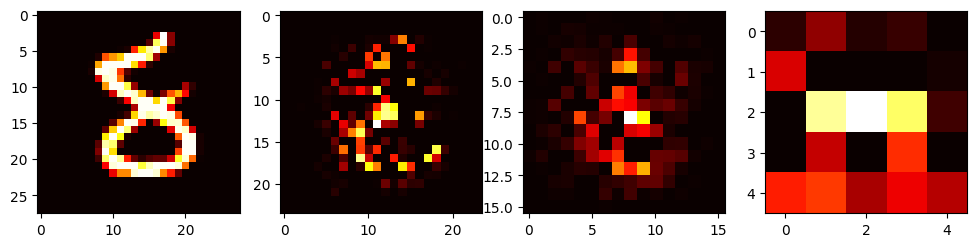

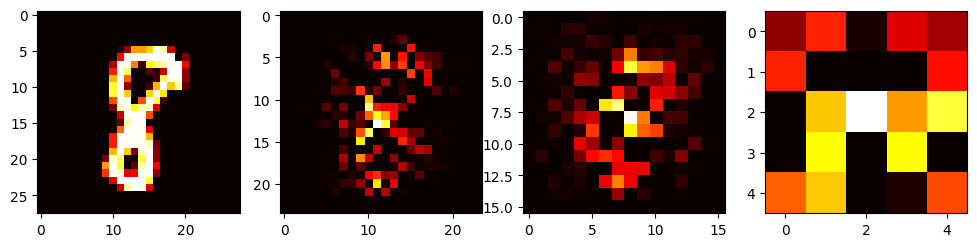

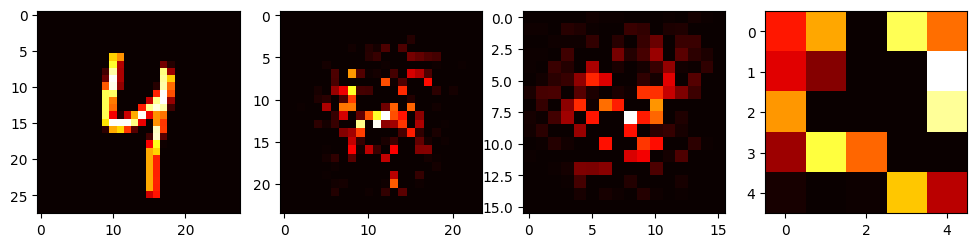

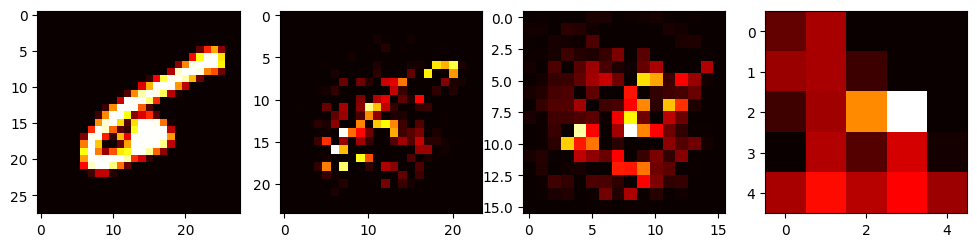

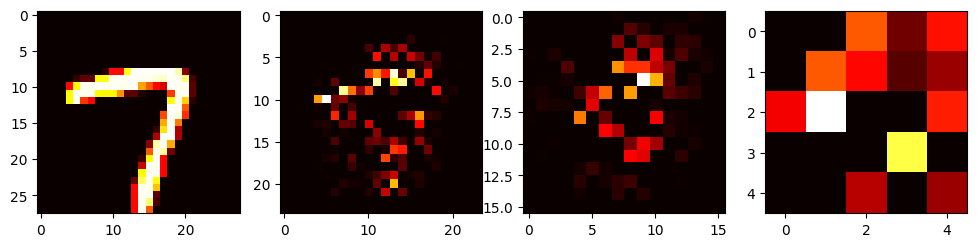

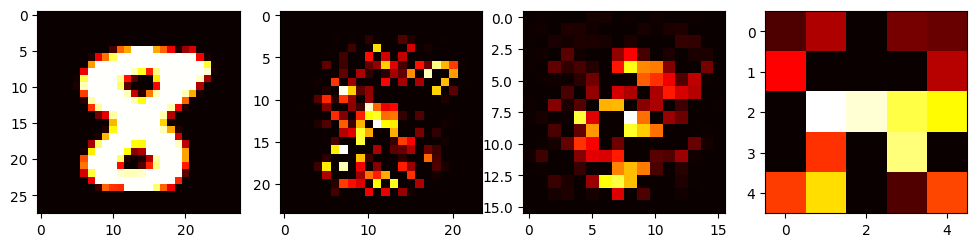

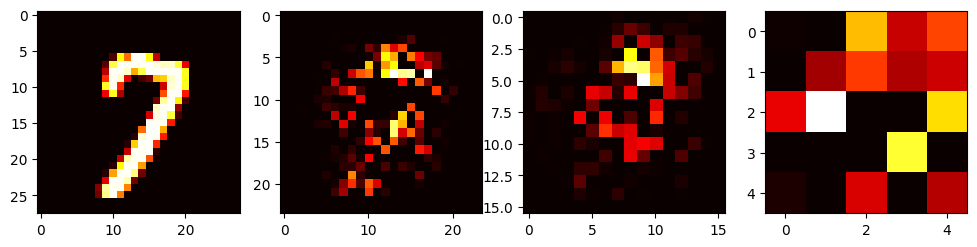

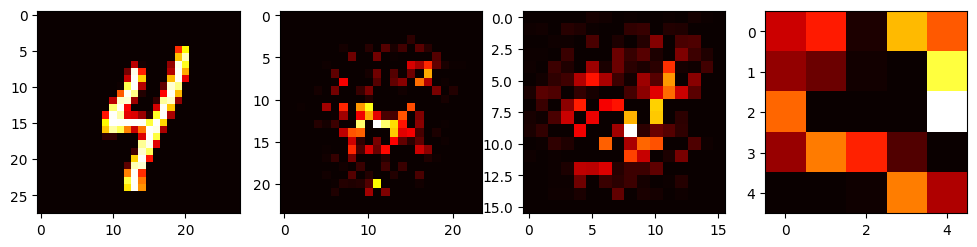

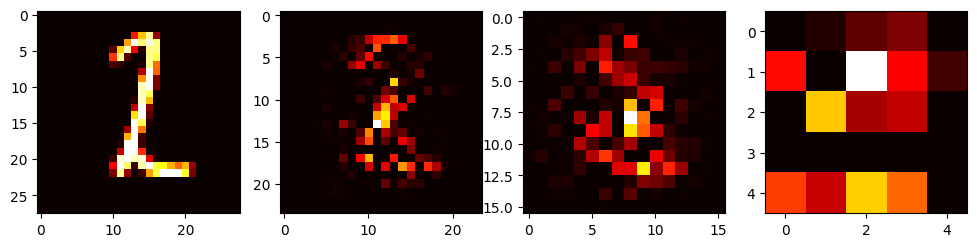

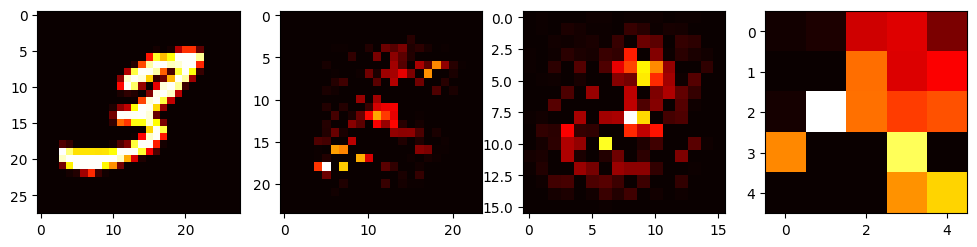

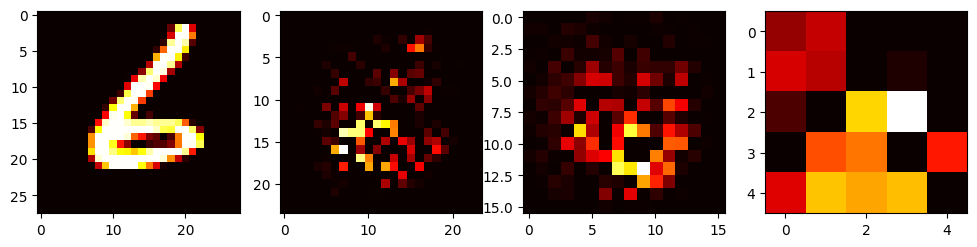

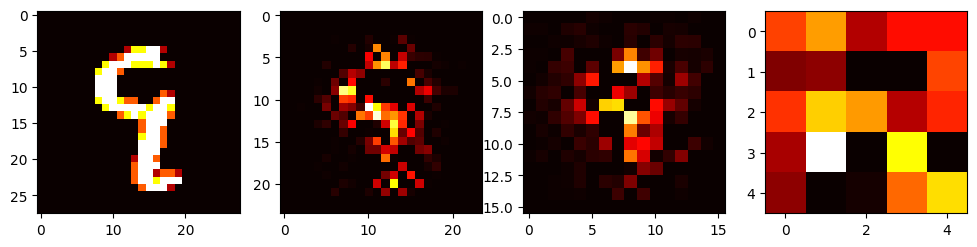

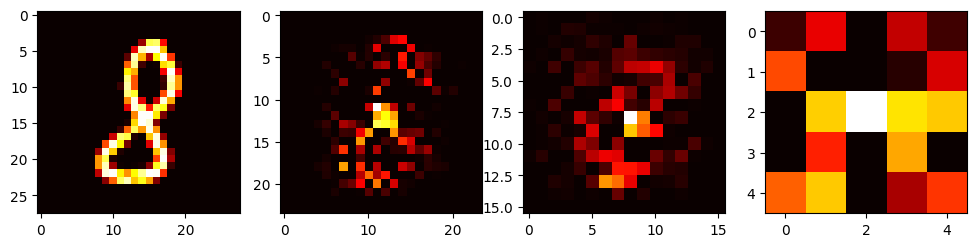

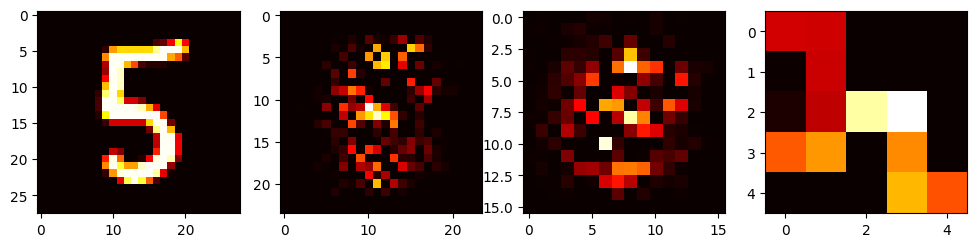

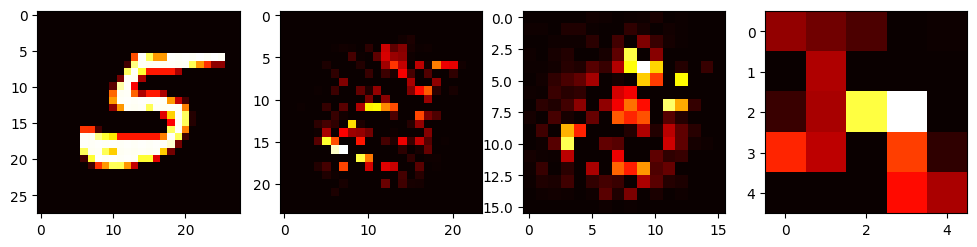

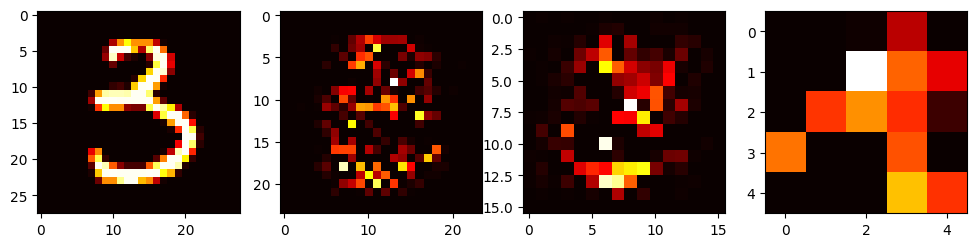

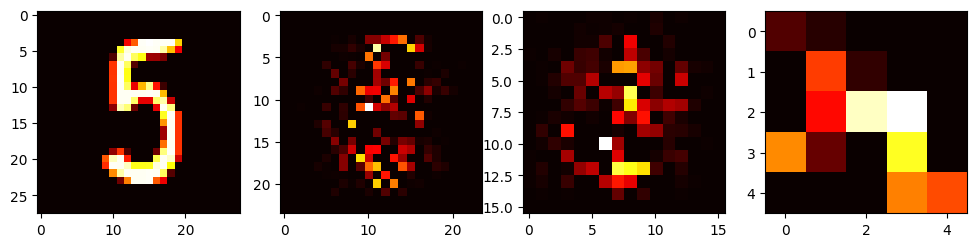

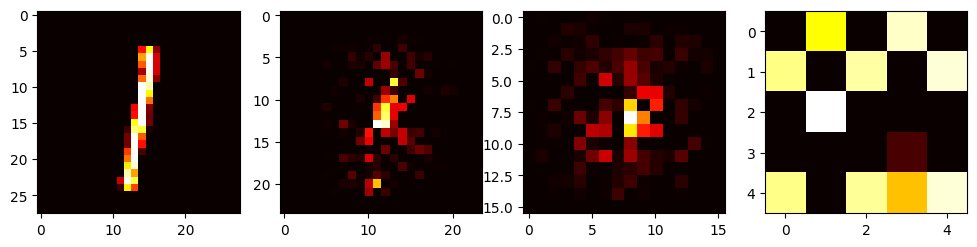

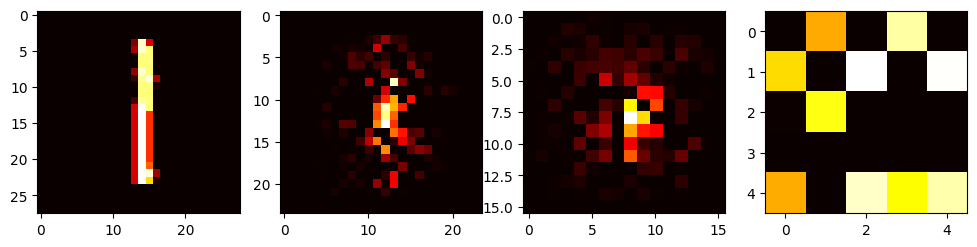

In [50]:
# Explore data
visualize_forward_pass(model4, train_loader, cmap="hot")